# Empirical Comparaison of True Online TD ($\lambda$) and Emphatic TD ($\lambda$)

In [1]:
import gym
import itertools
import numpy as np
import pandas as pd
import pdb
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
from collections import defaultdict

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
env = gym.envs.make("MountainCar-v0")
env.seed(42)

[2017-03-16 18:33:45,925] Making new env: MountainCar-v0


[42L]

In [3]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

n_components = 10

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=10, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=10, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=10, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=10, random_state=None))],
       transformer_weights=None)

In [4]:
def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0].reshape(n_components*4,1)

def getTDerror(r, gamma, theta, phi, phi1):
        
    delta = r+gamma*np.dot(theta.T,phi1)-np.dot(theta.T,phi)
    return delta
    
def policy_prob(phi, thetas_sarsa, epsilon=0.1, nA=3):
    prob = np.ones(nA) * epsilon / (nA-1)
    values = np.array([np.dot(phi.T, t) for t in thetas_sarsa])
    idx = np.argmax(values)
    prob[idx] = 1-epsilon
    return prob

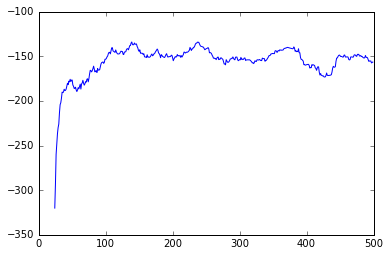

In [5]:
thetas_sarsa = []
for _ in range(env.action_space.n):
    thetas_sarsa.append(np.zeros((n_components*4,1)))

gamma = 0.99
nb_episodes = 500

rewards = np.zeros(nb_episodes)
alpha = 0.025

for i in range(nb_episodes):
    
    s = env.reset()
    phi=featurize_state(s)
    action_probs = policy_prob(phi, thetas_sarsa, nA=env.action_space.n)
    a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    
    r_tot = 0
    
    for steps in itertools.count():

        s1,r,done,_ = env.step(a)
        
        r_tot += r
        
        if done:
            thetas_sarsa[a] += alpha*(r-np.dot(phi.T, thetas_sarsa[a]))*phi
            break
            
        phi1 = featurize_state(s1)
        
        action_probs = policy_prob(phi1, thetas_sarsa, nA=env.action_space.n)
        a1 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        delta = r+gamma*np.dot(phi1.T, thetas_sarsa[a1]) - np.dot(phi.T, thetas_sarsa[a])
        thetas_sarsa[a] += alpha*delta*phi
        
        a,phi = a1,phi1
        

    rewards[i] = r_tot
    
    if i%100 == 0:
        alpha *= .99

plt.plot(pd.rolling_mean(rewards, 25)) 

# True Online TD

* True Online TD($\lambda$) exactly matches the forward view, while TD($\lambda$) only approximately matches it.
* Eligibility trace is given by $e_t=\gamma \lambda e_{t-1} + (1-\alpha \gamma \lambda e^T_{t-1}\phi_t)\phi_t$

In [6]:
def getMSPBE(first_term, second_term, steps):
    #pdb.set_trace()
    first_term /= steps
    second_term /= steps
    second_term_inverse = np.linalg.inv(second_term)
    return np.dot(np.dot(first_term.T, second_term_inverse), first_term)



def OTD(nb_episodes,thetas_sarsa,y = 0.99,alpha=0.01,l = 0.5):
    theta = np.zeros((n_components*4,1))
    MSPBE_OTD = np.zeros(nb_episodes)
    for i in range(nb_episodes):
        s = env.reset()
        phi = featurize_state(s)
        Vold = 0
        e = np.zeros((n_components*4,1))
        first_term = np.zeros((n_components*4,1))
        second_term = np.zeros((n_components*4,n_components*4))
    
        for steps in itertools.count():
        
            action_probs = policy_prob(phi, thetas_sarsa, nA=env.action_space.n, epsilon=0)
            a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            s1,r,done,_ = env.step(a)
            phi1 = featurize_state(s1)
        
            if done:
                phi1 *= 0
            
            V = np.dot(phi.T, theta)

            V1 = np.dot(phi1.T, theta)
            e = y*l*e + (1-alpha*y*l*np.dot(e.T, phi))*phi

            delta = getTDerror(r,y,theta,phi,phi1)

            first_term += delta*phi
            second_term += np.dot(phi, phi.T)
        
            theta += alpha*(delta+V-Vold)*e-alpha*(V-Vold)*phi
            Vold, phi = V1, phi1
            if done:
                break
        
        

        MSPBE_OTD[i] = getMSPBE(first_term, second_term, steps)
        if i%100 == 0:
            alpha *= .9
    
    return MSPBE_OTD

# Emphatic Temporal-Difference (ETD)

* ETD is an off-policy learning algorithm that selectively emphasis or de-emphasize the update on different time step.
* Stable for off-policy learning.
* The emphasis of an update depends on the interest of the state $S_t$, and the amount of bootstrapping the previous state $S_{t-1}$
* Eligibility trace is given by $e_t=\rho_t(\gamma_t \delta_t e_{t-1} + M_t \phi_t)$, where $M_t=\lambda_t i(S_t) + (1-\lambda_t)F_t$ and $F_t=i(S_t)+\gamma \rho_{t-1} F_{t-1}$

In [7]:
def ETD(nb_episodes,thetas_sarsa,epsilon=0.1,y = 0.99,alpha=0.025,interest = 1,l = 0.5):
    MSPBE_ETD = np.zeros(nb_episodes)
    theta = np.zeros((n_components*4,1))
    for i in range(nb_episodes):
        s = env.reset()
        phi = featurize_state(s)
        F = 0
        e = np.zeros((n_components*4,1))
        first_term = np.zeros((n_components*4,1))
        second_term = np.zeros((n_components*4,n_components*4))
    
        for steps in itertools.count():
            #a = env.action_space.sample()
            action_probs = policy_prob(phi, thetas_sarsa, nA=env.action_space.n, epsilon=epsilon)
            a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            p = policy_prob(phi, thetas_sarsa, nA=env.action_space.n, epsilon=0)[a]

            s1,r,done,_ = env.step(a)
            phi1 = featurize_state(s1)
        
            if done:
                phi1 *= 0
        
            F = interest + y*p*F
            M = l*interest + (1-l)*F
        
            e = p*(y*l*e+M*phi)

            delta = getTDerror(r,y,theta,phi,phi1)

            first_term += delta*phi
            second_term += np.dot(phi, phi.T)
        
            theta += alpha*(delta)*e
            phi, s = phi1, s1
            if done:
                break
        
        

        MSPBE_ETD[i] = getMSPBE(first_term, second_term, steps)
        
        if i%10 == 0:
            alpha *= .7
    
    return MSPBE_ETD
  
#plt.plot(pd.rolling_mean(MSPBE_ETD, 25))


In [8]:
def comparaison(nb_episodes,thetas_sarsa, l=0.5, epsilon=0.15):
    MSPBE_OTD = OTD(nb_episodes, thetas_sarsa, l=l)
    print "DONE"
    MSPBE_ETD = ETD(nb_episodes, thetas_sarsa, epsilon=epsilon, l=l)
    print "DONE"

    fig = plt.figure(figsize=(20, 10))

    CE, = plt.plot(pd.rolling_mean(np.sqrt(MSPBE_OTD),25), label="True Online TD")
    MC, = plt.plot(pd.rolling_mean(np.sqrt(MSPBE_ETD),25), label="Offline ETD")

    plt.title("MSPBE of the Value Function", fontsize=50)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Iteration',fontsize = 20)
    ax.set_ylabel('MSPBE', fontsize = 20)

    plt.legend(handles=[CE, MC])
    plt.show()

# Experiments

* We first learn a policy using Sarsa.
* We compare the evaluation of this policy using the Emphatic TD (ETD) and True Online TD.
* In the case of ETD, we let the behaviour policy be the same as the target policy with random actions chosen 10% of the time.
* We vary the trace-decay parameter $\lambda$ for our experiments.
* Interests are set to 1 for every state.

DONE
DONE


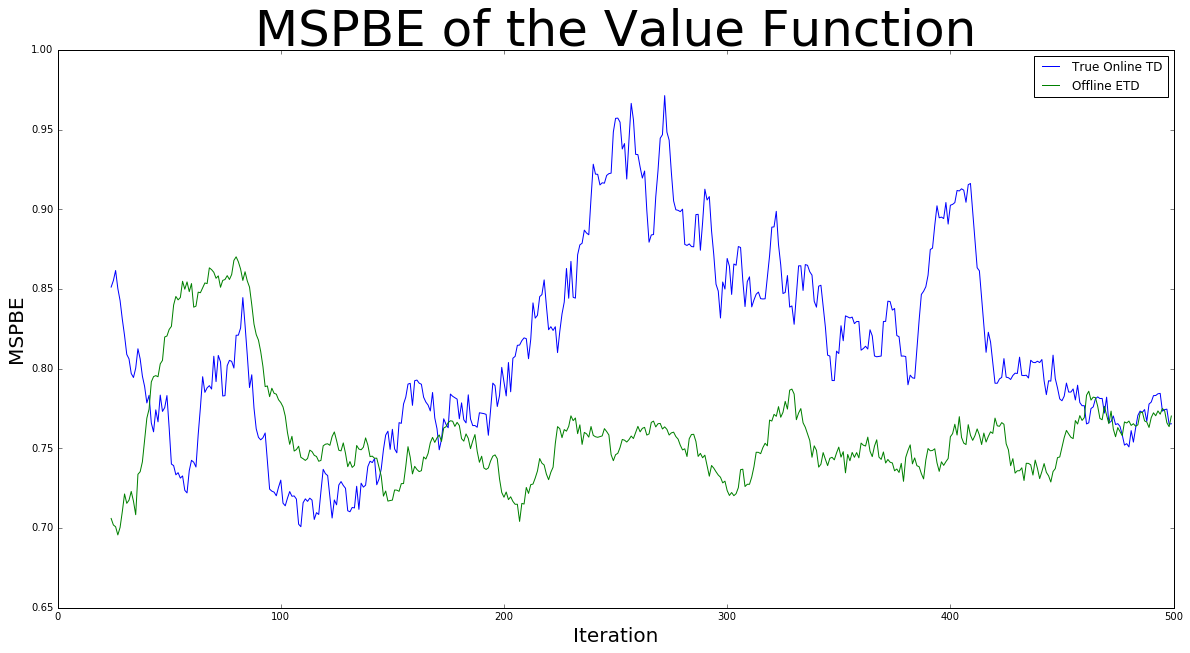

In [9]:
comparaison(nb_episodes=500, thetas_sarsa=thetas_sarsa, l=0)

DONE
DONE


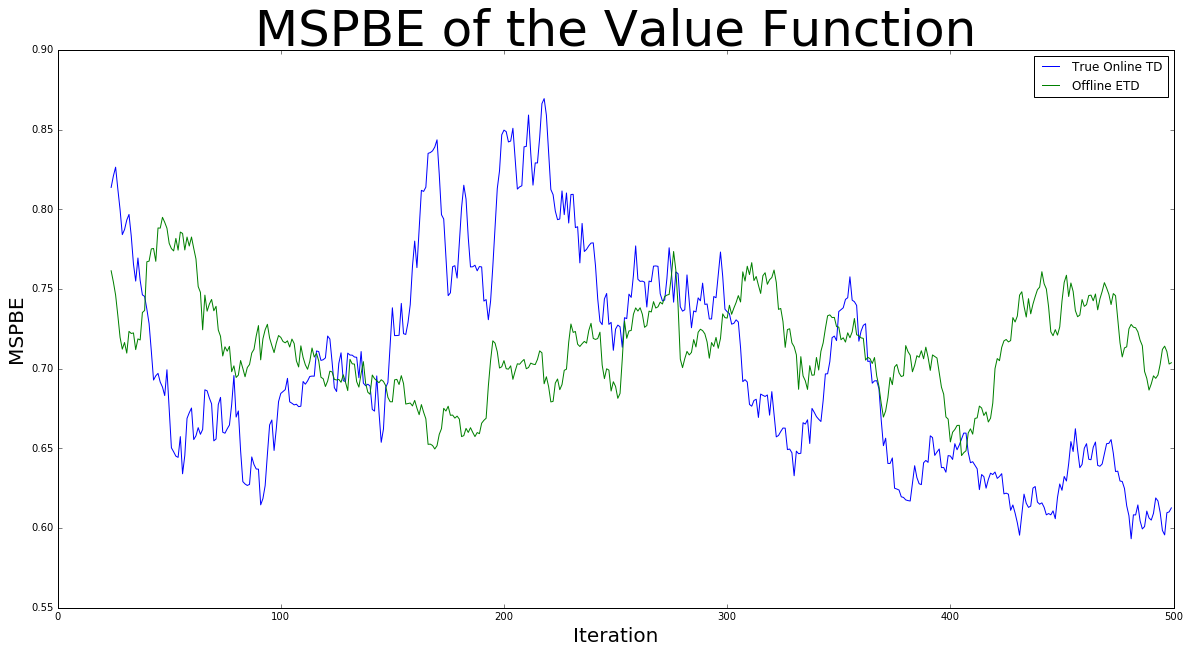

In [10]:
comparaison(nb_episodes=500, thetas_sarsa=thetas_sarsa, l=0.25)

DONE
DONE


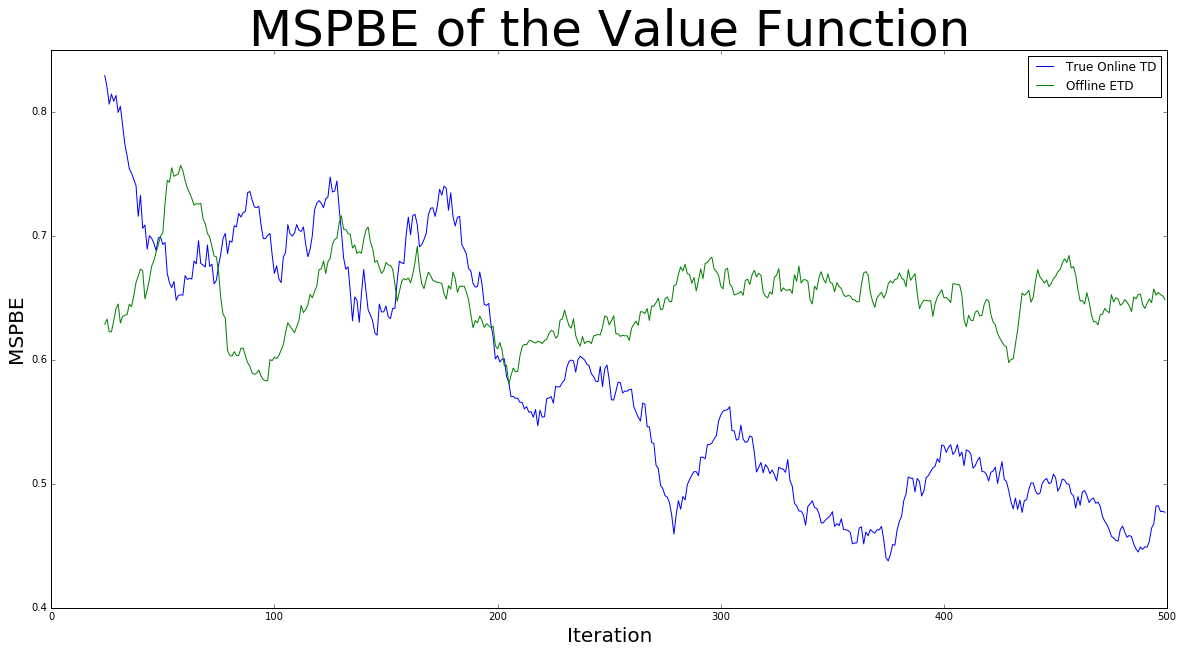

In [11]:
comparaison(nb_episodes=500, thetas_sarsa=thetas_sarsa, l=0.5)

DONE
DONE


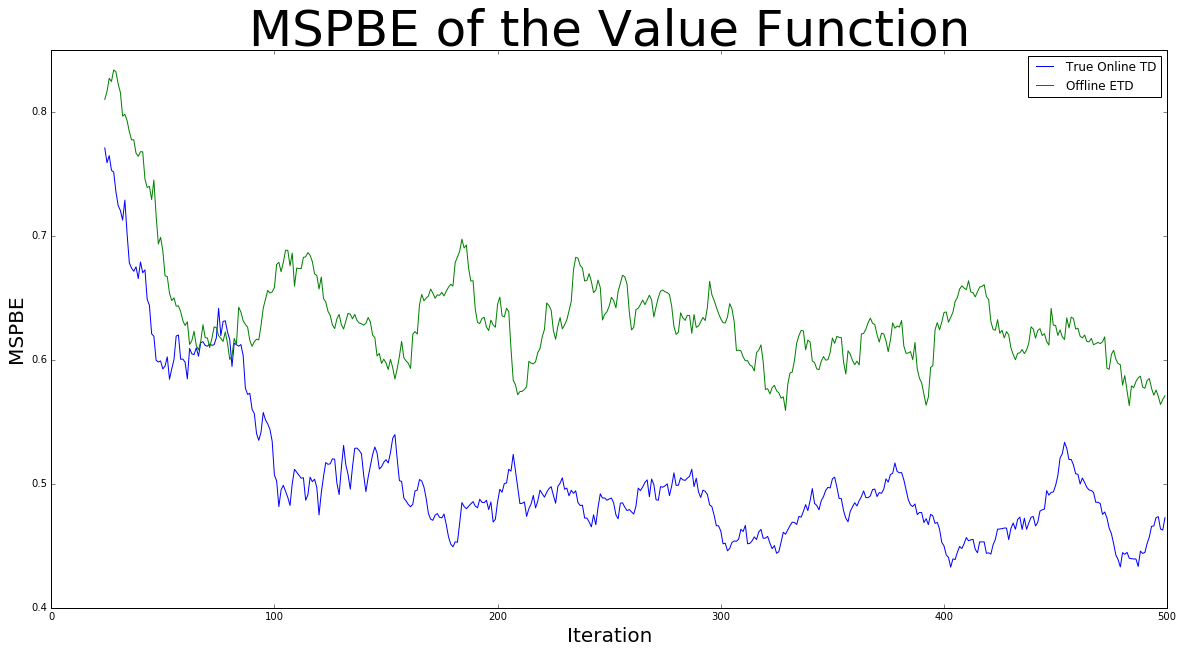

In [12]:
comparaison(nb_episodes=500, thetas_sarsa=thetas_sarsa, l=0.75)

DONE
DONE


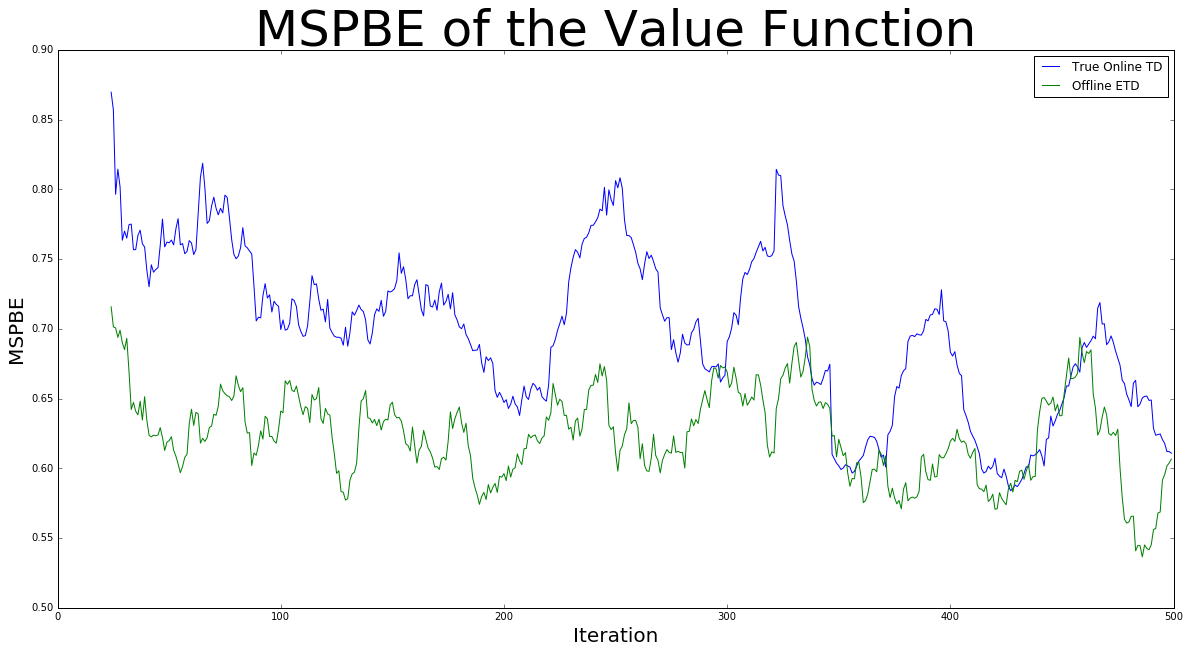

In [13]:
comparaison(nb_episodes=500, thetas_sarsa=thetas_sarsa, l=1)

# Conclusion

* The ETD algorithm performs fairly well and is competitive with the True Online TD. 
* Eligibility traces can be used to stabilize off-policy learning and to match the forward view of $TD(\lambda)$ in the online case.